In [62]:
import camb
import healpy
import mcmc_functions as func
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [63]:
import tensorflow as tf
import numpy as np

# Input data as an array/list
def compressor(original_data, out_dim):
    original_data = original_data.reshape(1, -1)
    print(original_data.shape[1])
    input_dim = original_data.shape[1]
    compressed_dim = out_dim

    # Encoder
    # Linear compression from the Dense layer. Default activation is Linear anyway.
    encoder_input = tf.keras.layers.Input(shape=(input_dim,))
    encoder_output = tf.keras.layers.Dense(compressed_dim, activation='linear')(encoder_input)
    encoder = tf.keras.Model(encoder_input, encoder_output)

    # Decoder
    decoder_input = tf.keras.layers.Input(shape=(compressed_dim,))
    decoder_output = tf.keras.layers.Dense(input_dim, activation='linear')(decoder_input)
    decoder = tf.keras.Model(decoder_input, decoder_output)

    # Combined autoencoder
    autoencoder_input = tf.keras.layers.Input(shape=(input_dim,))
    encoded = encoder(autoencoder_input)
    decoded = decoder(encoded)
    autoencoder = tf.keras.Model(autoencoder_input, decoded)

    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    history = autoencoder.fit(original_data, original_data, epochs=10, batch_size=32)
    compressed_data = encoder.predict(original_data)

    # Decompress the data
    #reconstructed_data = decoder.predict(compressed_data)


    # Weights of the encoder
    encoder_weights = encoder.get_weights()
    print("Encoder Weights:", encoder_weights)

    # Weights of the decoder
    #decoder_weights = decoder.get_weights()
    #print("Decoder Weights:", decoder_weights)

    return compressed_data, encoder_weights, history.history


In [64]:
observed_values = {'H0':67.6/1000, 
                   'ombh2': 0.0220, 
                   'omch2': 0.122, 
                   'mnu': 0.061, 
                   'tau': 0.050,
                   'As': 2.05e-9, 
                   'ns': 0.964}

observed_spectrum_cls, observed_spectrum_cl_hats = func.generate_cmb_power_spectrum(observed_values, cl_hats = True)

print(observed_spectrum_cl_hats)

[6.70628757e+00 5.48602673e+00 5.97028843e+00 ... 7.43068293e-05
 7.24131709e-05 7.11836491e-05]


In [81]:
compressed_data, weights, h = compressor(observed_spectrum_cl_hats, 7)
print(compressed_data)

2470
Epoch 1/10
1/1 [==============================] - 0s 329ms/sample - loss: 1.6470
Epoch 2/10
1/1 [==============================] - 0s 2ms/sample - loss: 1.5818
Epoch 3/10
1/1 [==============================] - 0s 2ms/sample - loss: 1.5548
Epoch 4/10
1/1 [==============================] - 0s 1ms/sample - loss: 1.5095
Epoch 5/10
1/1 [==============================] - 0s 2ms/sample - loss: 1.4565
Epoch 6/10
1/1 [==============================] - 0s 1ms/sample - loss: 1.4399
Epoch 7/10
1/1 [==============================] - 0s 1ms/sample - loss: 1.4085
Epoch 8/10
1/1 [==============================] - 0s 1ms/sample - loss: 1.3939
Epoch 9/10
1/1 [==============================] - 0s 1ms/sample - loss: 1.3841
Epoch 10/10
1/1 [==============================] - 0s 1ms/sample - loss: 1.3646
Encoder Weights: [array([[-0.03060651, -0.01011062, -0.01139071, ...,  0.03924708,
         0.04743247,  0.01558641],
       [-0.00497834, -0.03133076,  0.03148477, ..., -0.02302297,
        -0.00308172

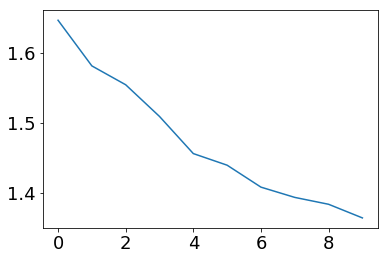

In [82]:
plt.plot(h['loss'])
plt.show()

In [94]:
nn_weights = weights[0]
bias = weights[1]

# REWRITE THIS
print(compressed_data.shape)
print(np.transpose(nn_weights).shape)
print(np.matmul(compressed_data, np.transpose(nn_weights)).shape)
print(nn_weights.shape)

(1, 7)
(7, 2470)
(1, 2470)
(2470, 7)


In [97]:
cov_matrix = np.matmul(np.matmul(compressed_data, np.transpose(nn_weights)), nn_weights)
print(cov_matrix.shape)
print(cov_matrix)
inv_cov_matrix = np.linalg.inv(cov_matrix)


(1, 7)
[[-2.2488608   0.8527664  -5.675568   -7.129945   -5.384793    2.278563
  -0.44086188]]


LinAlgError: Last 2 dimensions of the array must be square

In [46]:
print(observed_spectrum_cl_hats)

[3.88437021e+00 6.46193360e+00 7.37317295e+00 ... 7.49584172e-05
 7.31876769e-05 7.23930266e-05]


In [ ]:
import emcee

import emcee
import numpy as np


observed_values = {'H0':67.6/1000, 
                   'ombh2': 0.0220, 
                   'omch2': 0.122, 
                   'mnu': 0.061, 
                   'tau': 0.050,
                   'As': 2.05e-9, 
                   'ns': 0.964}

def log_likelihood(theta):
    H0, ombh2 = theta
    observed_values['H0'] = H0
    observed_values['ombh2'] = ombh2
    
    observed_spectrum_cls, observed_spectrum_cl_hats = func.generate_cmb_power_spectrum(observed_values, cl_hats = True)
    
    cov_matrix = func.calc_cov_theory(observed_spectrum_cls)
    inv_cov_matrix = np.linalg.inv(cov_matrix)
    probability = func.log_likelihood(observed_spectrum_cl_hats,fiducial_spectrum_cls,
                                    cov_matrix)
    
    return probability


# Define the prior distribution
def log_prior(theta):
    H0, ombh2 = theta
    print(theta)
    if 0.06 < H0 < 0.073 and 0.01 < ombh2 < 0.04:
        return 0.0
    return -np.inf

# Combine into the full log-probability function
def log_probability(theta):
    lp = log_prior(theta)
    print(lp, estimate(theta))
    if not np.isfinite(lp):
        return -np.inf
    return lp + estimate(theta)

# Example values for fiducial_dls and ls_range
fiducial_dls = fiducial_dataset_dl
ls_range = np.arange(10, max_index)

# Initialize the walkers
nwalkers, ndim = 20, 2
p0 = [0.066, 0.025] + 1e-5 * np.random.randn(nwalkers, ndim)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
sampler = emcee.EnsembleSampler(nwalkers, ndim, estimate)



In [ ]:
sampler.run_mcmc(p0, 500, progress=True)

# Get the chain of sampled parameters
samples = sampler.get_chain(flat=True)

In [ ]:
import pickle

with open('outputs/nn.pkl', 'wb') as f:
    pickle.dump(samples, f)


In [ ]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(["H0", "ombh2"][i]) 
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("Step number")
plt.show()

In [ ]:
import corner

fig = corner.corner(samples, smooth = 4.0, labels=["H0", "ombh2"],
                    truths=[0.70, 0.0022])  
plt.show()
print(samples.shape[0])